# Classification of the Oxford Flowers 102 dataset using PyTorch

Ok, one more CNN trained to classify an image dataset. This time I'm using the Oxford Flowers 102 dataset [[1]](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/), which contains 102 categories of flowers. This dataset has an unusual data split: the training and validation datasets each have relatively few images (1,020 i.e. 10 images per class), while the test dataset has 6,149 images. Below I switch them to use the largest dataset ('test') for training, and one of the smaller datasets for testing.

The data can be improved by applying pre-processing steps that segment the images and isolate the flowers from their background [[2]](https://doi.org/10.1109/ICVGIP.2008.47). Using the dataset as is, a CNN largely fails to accurately classify flowers from the test set.

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy

In [226]:
img_resize = 128

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_resize,img_resize)),
    v2.ToDtype(torch.float32, scale=True)
])

# train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
# val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
# test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [227]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
assert len(class_names)==102
classes = {i: class_names[i] for i in range(len(class_names))}

total_samples = {"alpine sea holly":43,"buttercup":71,"fire lily":40,"anthurium":105,"californian poppy":102,"foxglove":162,"artichoke":78,"camellia":91,"frangipani":166,"azalea":96,"canna lily":82,"fritillary":91,"ball moss":46,"canterbury bells":40,"garden phlox":45,"balloon flower":49,"cape flower":108,"gaura":67,"barbeton daisy":127,"carnation":52,"gazania":78,"bearded iris":54,"cautleya spicata":50,"geranium":114,"bee balm":66,"clematis":112,"giant white arum lily":56,"bird of paradise":85,"colt's foot":87,"globe thistle":45,"bishop of llandaff":109,"columbine":86,"globe-flower":41,"black-eyed susan":54,"common dandelion":92,"grape hyacinth":41,"blackberry lily":48,"corn poppy":41,"great masterwort":56,"blanket flower":49,"cyclamen ":154,"hard-leaved pocket orchid":60,"bolero deep blue":40,"daffodil":59,"hibiscus":131,"bougainvillea":128,"desert-rose":63,"hippeastrum ":76,"bromelia":63,"english marigold":65,"japanese anemone":55,"king protea":49,"peruvian lily":82,"stemless gentian":66,"lenten rose":67,"petunia":258,"sunflower":61,"lotus":137,"pincushion flower":59,"sweet pea":56,"love in the mist":46,"pink primrose":40,"sweet william":85,"magnolia":63,"pink-yellow dahlia?":109,"sword lily":130,"mallow":66,"poinsettia":93,"thorn apple":120,"marigold":67,"primula":93,"tiger lily":45,"mexican aster":40,"prince of wales feathers":40,"toad lily":41,"mexican petunia":82,"purple coneflower":85,"tree mallow":58,"monkshood":46,"red ginger":42,"tree poppy":62,"moon orchid":40,"rose":171,"trumpet creeper":58,"morning glory":107,"ruby-lipped cattleya":75,"wallflower":196,"orange dahlia":67,"siam tulip":41,"water lily":194,"osteospermum":61,"silverbush":52,"watercress":184,"oxeye daisy":49,"snapdragon":87,"wild pansy":85,"passion flower":251,"spear thistle":48,"windflower":54,"pelargonium":71,"spring crocus":42,"yellow iris":49}

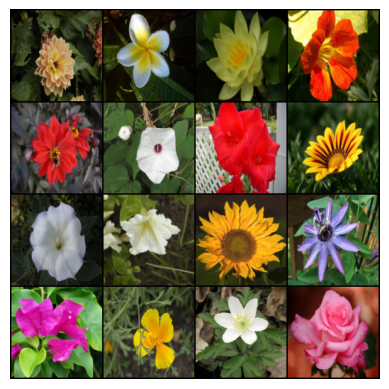

Labels:
pink-yellow dahlia?; frangipani; water lily; watercress;
bishop of llandaff; morning glory; sword lily; gazania;
thorn apple; petunia; sunflower; passion flower;
bougainvillea; californian poppy; windflower; rose;


In [228]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(DataLoader(train_dataset, batch_size=16, shuffle=True))
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=4))
# print labels
print("Labels:")
for i in range(4):
    print(' '.join(f'{classes[int(labels[j])]};' for j in range(i*4, (i+1)*4)))

In [229]:
mat = scipy.io.loadmat("./data/flowers-102/setid.mat")
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009', '__version__': '1.0', '__globals__': [], 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]],
      shape=(1, 1020), dtype=uint16), 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]],
      shape=(1, 1020), dtype=uint16), 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]],
      shape=(1, 6149), dtype=uint16)}


In [230]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(img_resize//8 * img_resize//8 * 128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 102)
        # Activation and dropout

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Define how data flows through the network
        x = self.pool(F.relu(self.conv1(x)))  # n x n x 32  -> n/2 x n/2 x 32
        x = self.pool(F.relu(self.conv2(x)))  #             -> n/4 x n/4 x 64
        x = self.pool(F.relu(self.conv3(x)))  #             -> n/8 x n/8 x 128
        x = x.view(-1, img_resize//8 * img_resize//8 * 128)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [231]:
model = SimpleCNN() # creates an object (an instance of the SimpleCNN class), ! not a function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [232]:
def train_CNN(model, train_loader, criterion, optimizer, epochs=2):
    model.train()  # Set model to training mode, see https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            inputs, labels = data

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear old gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update weights
            
            running_loss += loss.item()
            
            # Print progress
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}\n')

train_CNN(model, train_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Batch 0/49, Loss: 4.6255
Epoch 1 complete. Average Loss: 4.3063

Epoch 2/20, Batch 0/49, Loss: 3.8723
Epoch 2 complete. Average Loss: 3.6973

Epoch 3/20, Batch 0/49, Loss: 3.3049
Epoch 3 complete. Average Loss: 3.2821

Epoch 4/20, Batch 0/49, Loss: 3.0360
Epoch 4 complete. Average Loss: 2.9796

Epoch 5/20, Batch 0/49, Loss: 3.0389
Epoch 5 complete. Average Loss: 2.7211

Epoch 6/20, Batch 0/49, Loss: 2.6200
Epoch 6 complete. Average Loss: 2.5686

Epoch 7/20, Batch 0/49, Loss: 2.3074
Epoch 7 complete. Average Loss: 2.3282

Epoch 8/20, Batch 0/49, Loss: 2.2118
Epoch 8 complete. Average Loss: 2.1782

Epoch 9/20, Batch 0/49, Loss: 2.1562
Epoch 9 complete. Average Loss: 2.0544

Epoch 10/20, Batch 0/49, Loss: 1.8362
Epoch 10 complete. Average Loss: 1.8017

Epoch 11/20, Batch 0/49, Loss: 1.7726
Epoch 11 complete. Average Loss: 1.6549

Epoch 12/20, Batch 0/49, Loss: 1.2928
Epoch 12 complete. Average Loss: 1.4762

Epoch 13/20, Batch 0/49, Loss: 1.1782
Epoch 13 complete. Average Loss:

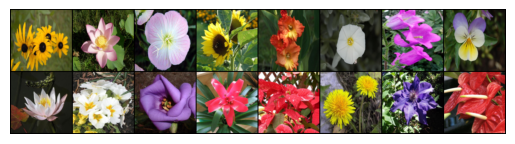

GroundTruth: 	 0=black-eyed susan | 1=lotus | 2=pink primrose | 3=sunflower | 4=sword lily | 5=silverbush | 6=canterbury bells | 7=wild pansy | 8=water lily | 9=primula | 10=bolero deep blue | 11=bromelia | 12=poinsettia | 13=common dandelion | 14=clematis | 15=anthurium |
Predicted: 	 0=wallflower | 1=lotus | 2=pink primrose | 3=gazania | 4=orange dahlia | 5=silverbush | 6=foxglove | 7=wild pansy | 8=lotus | 9=frangipani | 10=clematis | 11=trumpet creeper | 12=poinsettia | 13=daffodil | 14=balloon flower | 15=poinsettia |


In [233]:
n_show = 16
dataiter = iter(DataLoader(val_dataset, batch_size=n_show, shuffle=True))
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \t', ' '.join(f'{j}={classes[int(labels[j])]} |' for j in range(n_show)))

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: \t', ' '.join(f'{j}={classes[int(predicted[j])]} |' for j in range(n_show)))

### Calculating the overall test accuracy and the accuracy for each class

In [237]:
# Accuracy
correct = 0
total = 0

# count predictions for each class
correct_pred = {classname: 0 for classname in classes.values()}
total_pred = {classname: 0 for classname in classes.values()}

y_pred = []
y_true = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Totals for calculating accuracy
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[int(label)]] += 1
            total_pred[classes[int(label)]] += 1
            y_pred.append(prediction)
            y_true.append(label)

print(f'Overall accuracy of the network on 1,020 test images: {100 * correct // total} %\n')

# print accuracy for each class
print('Accuracy for each class (10 test samples per class):\n')

# pretty print
max_len = max([len(c) for c in classes.values()])
spaces = {c: ' '*(max_len - len(c)) for c in classes.values()}

accuracy_vs_sample_size = dict()

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname}{spaces[classname]}: {accuracy:.1f} % (total samples {total_samples[classname]})')
    
    accuracy_vs_sample_size[total_samples[classname] - 20] = accuracy # number of samples in training set = total samples - 10 in validation set - 10 in test set

Overall accuracy of the network on 1,020 test images: 39 %

Accuracy for each class (10 test samples per class):

pink primrose            : 30.0 % (total samples 40)
hard-leaved pocket orchid: 90.0 % (total samples 60)
canterbury bells         : 0.0 % (total samples 40)
sweet pea                : 0.0 % (total samples 56)
english marigold         : 20.0 % (total samples 65)
tiger lily               : 20.0 % (total samples 45)
moon orchid              : 50.0 % (total samples 40)
bird of paradise         : 80.0 % (total samples 85)
monkshood                : 20.0 % (total samples 46)
globe thistle            : 30.0 % (total samples 45)
snapdragon               : 10.0 % (total samples 87)
colt's foot              : 50.0 % (total samples 87)
king protea              : 30.0 % (total samples 49)
spear thistle            : 70.0 % (total samples 48)
yellow iris              : 60.0 % (total samples 49)
globe-flower             : 20.0 % (total samples 41)
purple coneflower        : 90.0 % (total

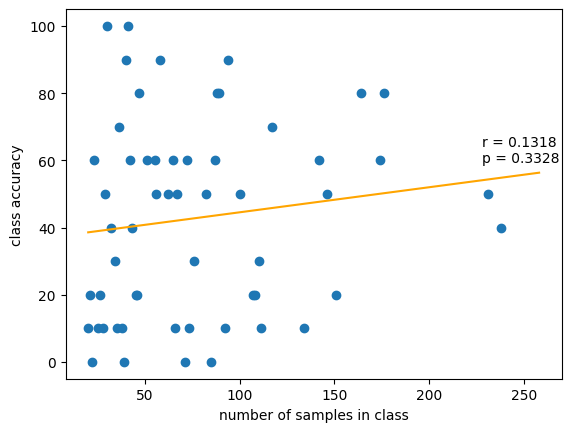

In [238]:
from scipy import stats

x = list(accuracy_vs_sample_size.keys())
y = list(accuracy_vs_sample_size.values())

slope, intercept, r, p, std_err = stats.linregress(x, y)

xs = np.linspace(20, max(total_samples.values()), num=len(x))
ys = slope * xs + intercept

# Plot regression line
plt.figure()
plt.scatter(x, y)
plt.plot(xs, ys, color="orange")
plt.annotate(f"r = {r:.4f}\np = {p:.4f}", xy=(xs[-1]-30,ys[-1]+3))
plt.xlabel("number of samples in class")
plt.ylabel("class accuracy")
plt.show()

<Axes: >

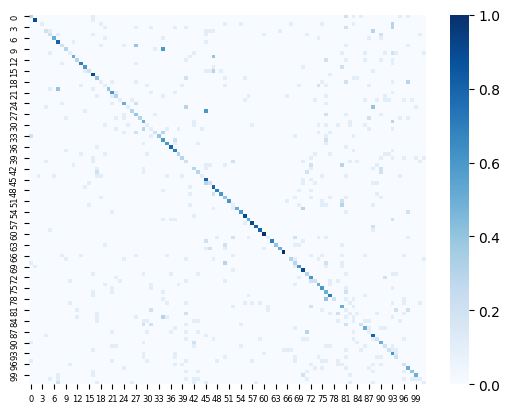

In [239]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure()
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
sns.heatmap(df_cm, annot=False, cmap='Blues')